In [1]:
%load_ext autotime
import seaborn as sns
import pandas as pd
import numpy as np


from gscore.parsers import sqmass
from gscore.parsers.osw import OSWFile
from gscore.parsers import queries


time: 1.24 s (started: 2022-01-31 15:33:00 +01:00)


In [2]:
sqmass_file_path = "/home/aaron/projects/ghost/data/spike_in/chromatograms/AAS_P2009_167.sqMass"
osw_file_path = "/home/aaron/projects/ghost/data/spike_in/openswath/AAS_P2009_167.osw"
with sqmass.SqMassFile(sqmass_file_path) as sqmass_file:
    chromatograms = sqmass_file.parse()
with OSWFile(osw_file_path) as osw_file:
    precursors = osw_file.parse_to_precursors(
        query=queries.SelectPeakGroups.FETCH_CHROMATOGRAM_TRAINING_RECORDS
    )
precursors.set_chromatograms(chromatograms)

Cleaning unused score columns.
time: 1min 51s (started: 2022-01-31 15:33:04 +01:00)


In [3]:
labels = []
scores = []
chroms = []

for precursor in precursors:

    precursor.peakgroups.sort(key=lambda x: x.scores["PROBABILITY"], reverse=True)

    peakgroup = precursor.peakgroups[0]

    if peakgroup.chromatograms:

        score_array = peakgroup.get_sub_score_column_array(True)

        scores.append(np.array(score_array))

        labels.append(peakgroup.target)

        chroms.append(
            peakgroup.get_chromatogram_intensity_arrays(
                interpolated=True, use_relative_intensities=True
            )
        )


labels = np.array(labels).reshape(-1, 1)
scores = np.array(scores)
chroms = np.array(chroms).reshape((-1, 1, 6, 25))

time: 24.1 s (started: 2022-01-31 15:35:16 +01:00)


In [4]:
from gscore.models.deep_chrom_feature_classifier import DeepChromFeatureScorer

time: 206 µs (started: 2022-01-31 15:35:57 +01:00)


In [5]:
from gscore.scaler import Scaler

time: 792 µs (started: 2022-01-31 15:35:58 +01:00)


In [6]:
scaler = Scaler()

scores = scaler.fit_transform(scores)

time: 64.2 ms (started: 2022-01-31 15:36:00 +01:00)


In [7]:
scores.shape

(49062, 33)

time: 7.05 ms (started: 2022-01-31 15:36:08 +01:00)


In [8]:
model = DeepChromFeatureScorer(
    num_features=33,
    threads=10,
    max_epochs=5
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


time: 53.2 ms (started: 2022-01-31 15:36:16 +01:00)


In [9]:
model.fit(
    chroms,
    scores,
    labels
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | conv_layers   | Sequential | 10.9 K
1 | linear_layers | Sequential | 2.1 M 
---------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.317     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

time: 31.2 s (started: 2022-01-31 15:36:17 +01:00)


In [10]:
scaler.save("/home/aaron/projects/ghost/data/spike_in/deepchrom/dc_v_t_1_29.scaler")

time: 3.87 ms (started: 2022-01-31 15:37:01 +01:00)


In [11]:
model.save("/home/aaron/projects/ghost/data/spike_in/deepchrom/dc_v_t_1_29.model")

time: 39.3 ms (started: 2022-01-31 15:37:02 +01:00)


In [12]:
model.evaluate(
    chroms,
    scores,
    labels
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/home/aaron/miniconda3/envs/ghostdev/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:172: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


0.832254116554846

time: 1.2 s (started: 2022-01-31 15:37:04 +01:00)


In [13]:
predictions = model.score(
    chromatograms=chroms,
    scores=scores
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

time: 1.11 s (started: 2022-01-31 15:37:40 +01:00)


In [14]:
import seaborn as sns
import pandas as pd

time: 907 µs (started: 2022-01-31 15:37:56 +01:00)


In [16]:
predictions.shape

(49062, 1)

time: 3.31 ms (started: 2022-01-31 15:38:39 +01:00)


In [17]:
df = pd.DataFrame(
    {
        "score": predictions.ravel(),
        "label": labels.ravel()
    }
)

time: 2.61 ms (started: 2022-01-31 15:38:48 +01:00)


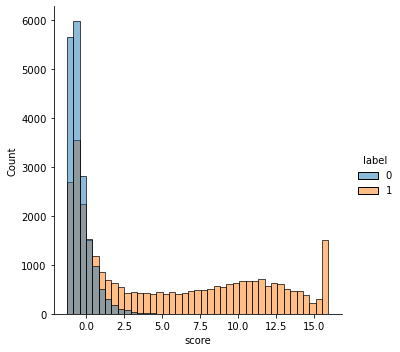

time: 370 ms (started: 2022-01-31 15:39:07 +01:00)


In [18]:
sns.displot(
    data=df,
    x="score",
    hue="label"
)

In [19]:
sqmass_file_path = "/home/aaron/projects/ghost/data/spike_in/chromatograms/AAS_P2009_168.sqMass"
osw_file_path = "/home/aaron/projects/ghost/data/spike_in/openswath/AAS_P2009_168.osw"
with sqmass.SqMassFile(sqmass_file_path) as sqmass_file:
    chromatograms = sqmass_file.parse()
with OSWFile(osw_file_path) as osw_file:
    precursors = osw_file.parse_to_precursors(
        query=queries.SelectPeakGroups.FETCH_CHROMATOGRAM_TRAINING_RECORDS
    )
precursors.set_chromatograms(chromatograms)
labels = []
scores = []
chroms = []

for precursor in precursors:

    precursor.peakgroups.sort(key=lambda x: x.scores["PROBABILITY"], reverse=True)

    peakgroup = precursor.peakgroups[0]

    if peakgroup.chromatograms:
        score_array = peakgroup.get_sub_score_column_array(True)

        scores.append(np.array(score_array))

        labels.append(peakgroup.target)

        chroms.append(
            peakgroup.get_chromatogram_intensity_arrays(
                interpolated=True, use_relative_intensities=True
            )
        )

labels = np.array(labels).reshape(-1, 1)
scores = np.array(scores)
chroms = np.array(chroms).reshape((-1, 1, 6, 25))

Cleaning unused score columns.
time: 2min 22s (started: 2022-01-31 16:34:29 +01:00)


In [20]:
scores = scaler.transform(scores)

time: 10.5 ms (started: 2022-01-31 16:37:42 +01:00)


In [21]:
predictions = model.score(
    chromatograms=chroms,
    scores=scores
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

time: 1.31 s (started: 2022-01-31 16:37:43 +01:00)


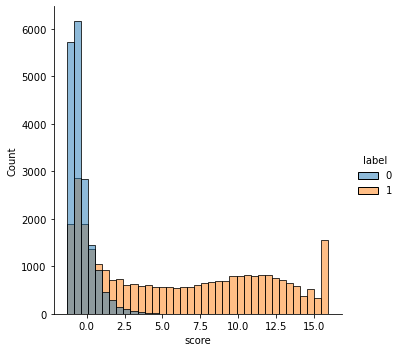

time: 328 ms (started: 2022-01-31 16:38:01 +01:00)


In [22]:
df = pd.DataFrame(
    {
        "score": predictions.ravel(),
        "label": labels.ravel()
    }
)
sns.displot(
    data=df,
    x="score",
    hue="label"
)